In [1]:
import pandas as pd

In [2]:
import numpy as np

In [12]:
df = pd.read_csv(r"C:\Users\Megha\jupyter\Solar-irradiance-code-files\data.csv")

"""
This script reads data from 'data.csv'.
Ensure the folder structure is:
- T-SAT.ipynb
- data.csv
"""

In [4]:
df.head()

,year,month,day,ALLSKY_SFC_SW_DWN,T2M,CLOUD_AMT,RH2M,HR_SIN,HR_COS,DAY_SIN,DAY_COS,SEASON_Autumn,SEASON_Monsoon,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,2020,1,1,0.0,0.129363,0.7876,0.546526,0.000000,1.000000,0.974928,-0.222521,0,0,0,0,1
1,2020,1,1,0.0,0.114784,0.9109,0.573478,0.258819,0.965926,0.974928,-0.222521,0,0,0,0,1
2,2020,1,1,0.0,0.104723,0.8085,0.592334,0.500000,0.866025,0.974928,-0.222521,0,0,0,0,1
3,2020,1,1,0.0,0.095893,0.5953,0.611293,0.707107,0.707107,0.974928,-0.222521,0,0,0,0,1
4,2020,1,1,0.0,0.089733,0.5087,0.622976,0.866025,0.500000,0.974928,-0.222521,0,0,0,0,1


In [6]:
# 1. Define features and target
features = ['T2M', 'CLOUD_AMT', 'RH2M', 'HR_SIN', 'HR_COS', 'DAY_SIN', 'DAY_COS'] + \
           [col for col in df.columns if col.startswith('SEASON_')]
target = 'ALLSKY_SFC_SW_DWN'

# 2. Extract features and target
X = df[features].values
y = df[target].values

In [7]:
# 3. Create Sequences
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]  # Features
        y = target[i + seq_length]  # Target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [8]:
seq_length = 24  # sequence length
X_seq, y_seq = create_sequences(X, y, seq_length)

In [9]:
# 4. Split into train, validation, and test sets
split_ratio = 0.7
split_index = int(len(X_seq) * split_ratio)


# 80% for training, 10% for validation, and 10% for testing
X_train, X_temp = X_seq[:split_index], X_seq[split_index:]
y_train, y_temp = y_seq[:split_index], y_seq[split_index:]

# Further split the remaining 30% into validation and test sets
val_split_ratio = 0.5  # 50% of the remaining data for validation
val_split_index = int(len(X_temp) * val_split_ratio)

X_val, X_test = X_temp[:val_split_index], X_temp[val_split_index:]
y_val, y_test = y_temp[:val_split_index], y_temp[val_split_index:]

In [10]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (28106, 24, 12), Val: (6023, 24, 12), Test: (6023, 24, 12)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D, Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa

# --- Positional Encoding Layer ---
class PositionalEncoding(Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]  # Get the sequence length (24)
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Sequence positions
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]  # Feature indices
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))  # Scaling factors
        angle_rads = pos * angle_rates  # Calculate angles

        # Compute sin and cos for odd and even indices in the encoding
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)  # Combine sines and cosines

        pos_encoding = pos_encoding[tf.newaxis, ...]  # Add batch dimension: (1, seq_len, d_model)
        return x + pos_encoding  # Broadcast pos_encoding to match the batch size


# --- Transformer Encoder Block ---
def transformer_encoder(x, num_heads, key_dim, ff_dim, dropout_rate, l2_reg=0.001, return_attention=False, name=None):
    # Layer normalization
    norm_x = LayerNormalization(epsilon=1e-6)(x)

    # Multi-head attention (set `output_attentions=True`)
    attn_layer = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout_rate, name=f'{name}_attn')
    attn_output, attn_scores = attn_layer(norm_x, norm_x, return_attention_scores=True)

    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])

    # Feed forward
    ffn_input = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = Dense(ff_dim, activation='relu', kernel_regularizer=l2(l2_reg))(ffn_input)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(ff_dim, kernel_regularizer=l2(l2_reg))(ffn_output)
    x = Add()([x, ffn_output])

    if return_attention:
        return x, attn_scores
    return x


# --- Full TST Model ---
def build_tst_model(input_shape, num_blocks=3, d_model=64, num_heads=2, ff_dim=64, dropout_rate=0.4, l2_reg=0.005):
    inputs = Input(shape=input_shape)

    # Project to d_model dimensions
    x = Dense(d_model, activation='relu', kernel_regularizer=l2(l2_reg))(inputs)
    x = Dropout(dropout_rate)(x)

    # Add positional encoding
    x = PositionalEncoding(d_model)(x)

    # Stack Transformer Encoder Blocks
    for i in range(num_blocks):
        x = transformer_encoder(
        x, 
        num_heads, 
        key_dim=d_model // num_heads, 
        ff_dim=ff_dim, 
        dropout_rate=dropout_rate, 
        l2_reg=l2_reg, 
        name=f'transformer_encoder_{i + 1}'
    )
        
    # Output head
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    outputs = Dense(1)(x)  # Regression output

    return Model(inputs, outputs)

# --- Model Training ---
def train_model(X_train, y_train, X_val, y_val, input_shape, num_blocks=3, d_model=64, num_heads=2, ff_dim=64, dropout_rate=0.25):
    model = build_tst_model(input_shape, num_blocks, d_model, num_heads, ff_dim, dropout_rate)
    
    # Instantiate the AdamW optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    return model, history



In [22]:
# Train the model with the specified parameters
model, history = train_model(X_train, y_train, X_val, y_val, input_shape=(24, 12), num_blocks=3, d_model=64)

Epoch 1/20
440/440 [==============================] - 20s 40ms/step - loss: 1.5390 - mae: 0.1236 - val_loss: 0.9187 - val_mae: 0.0542 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 17s 39ms/step - loss: 0.6206 - mae: 0.0526 - val_loss: 0.3991 - val_mae: 0.0396 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - 18s 40ms/step - loss: 0.2781 - mae: 0.0456 - val_loss: 0.1846 - val_mae: 0.0380 - lr: 0.0010
Epoch 4/20
440/440 [==============================] - 17s 40ms/step - loss: 0.1311 - mae: 0.0414 - val_loss: 0.0893 - val_mae: 0.0423 - lr: 0.0010
Epoch 5/20
440/440 [==============================] - 18s 40ms/step - loss: 0.0646 - mae: 0.0413 - val_loss: 0.0460 - val_mae: 0.0383 - lr: 0.0010
Epoch 6/20
440/440 [==============================] - 18s 40ms/step - loss: 0.0335 - mae: 0.0406 - val_loss: 0.0249 - val_mae: 0.0409 - lr: 0.0010
Epoch 7/20
440/440 [==============================] - 18s 40ms/step - loss: 0.0184 - mae: 0.0380 - val_loss: 0.0176 - 

## diagnostic plots:

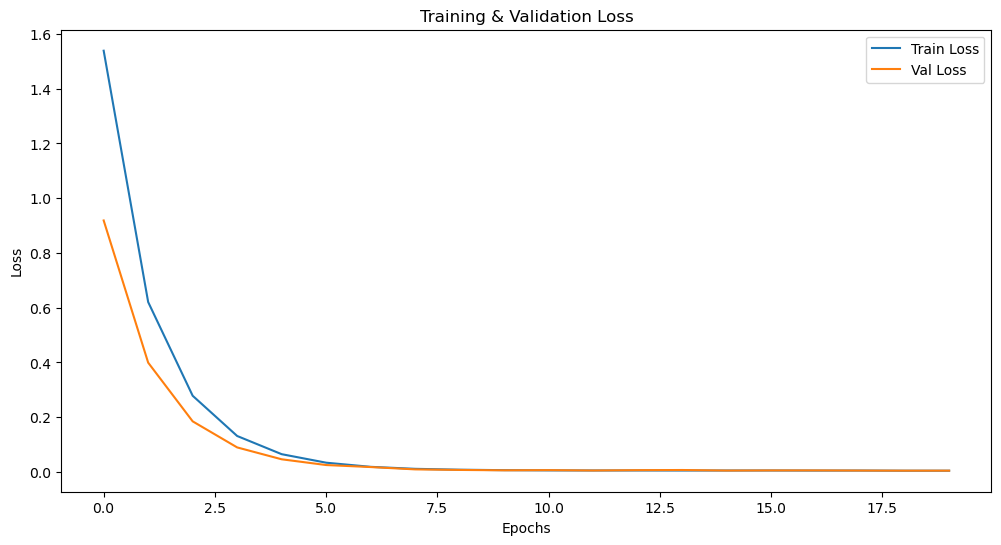

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

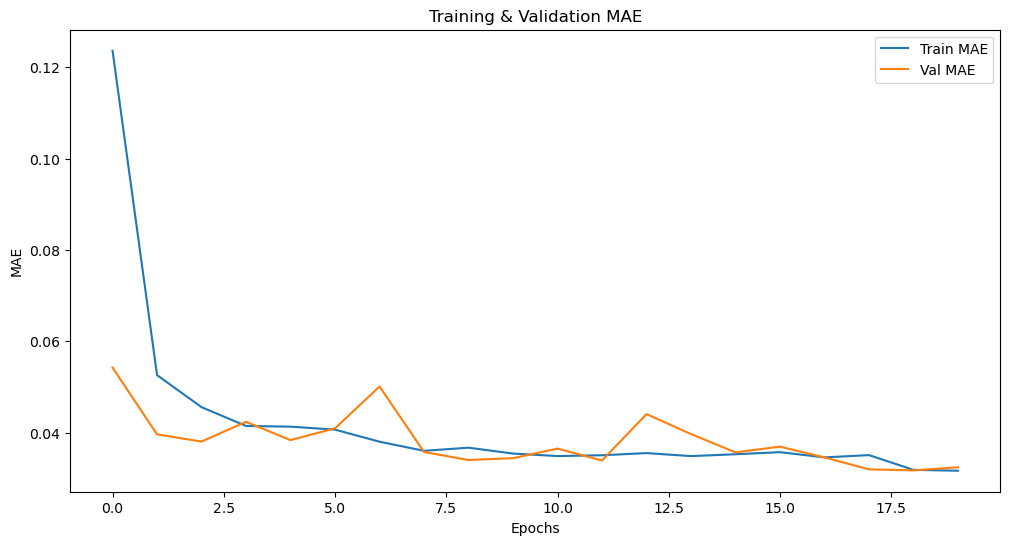

In [24]:
# Plot MAE if you want
plt.figure(figsize=(12,6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training & Validation MAE')
plt.show()

189/189 [==============================] - 1s 6ms/step


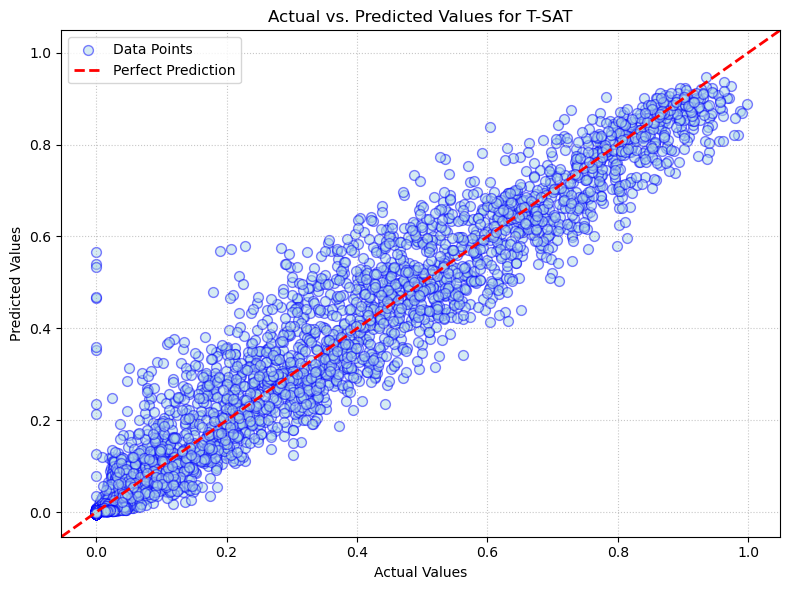

In [45]:
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

# Assume your model is trained and 'model' object is available.
# Assume X_test and y_test are defined from your splitting code.
# For demonstration purposes, let's create dummy data if you don't have it ready:
# np.random.seed(84)
# y_test = np.random.rand(50) * 100
# y_pred_test = y_test + np.random.randn(50) * 12 - 7 # Simulated predictions for test

# Predict on test data
y_pred_test = model.predict(X_test).flatten()

# --- Plotting Actual vs. Predicted for Test Set ---
plt.figure(figsize=(8,6)) # Make the figure slightly larger

# Scatter plot for actual vs. predicted values
plt.scatter(y_test, y_pred_test,
            s=50,             # Slightly larger markers
            alpha=0.5,        # Good transparency to show density
            color='lightblue', # A different pleasant color for test set to distinguish
            edgecolors='blue', # Darker edge for better definition
            label='Data Points') # Label for legend

# Perfect prediction line (y=x)
min_test_plot = min(y_test.min(), y_pred_test.min())
max_test_plot = max(y_test.max(), y_pred_test.max())
buffer_test = (max_test_plot - min_test_plot) * 0.05
plot_range_test = np.linspace(min_test_plot - buffer_test, max_test_plot + buffer_test, 100)

plt.plot(plot_range_test, plot_range_test,
         color='red',    # Green for clear distinction (different from validation's red line)
         linestyle='--',   # Dashed line
         linewidth=2,      # Slightly thicker line
         label='Perfect Prediction') # Label for legend

# Axis Labels
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)

# Title (emphasizing it's the Test Set)
plt.title('Actual vs. Predicted Values for T-SAT')
# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Add a legend
plt.legend(fontsize=10)

# Adjust plot limits
plt.xlim(min_test_plot - buffer_test, max_test_plot + buffer_test)
plt.ylim(min_test_plot - buffer_test, max_test_plot + buffer_test)

# Improve tick mark visibility
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

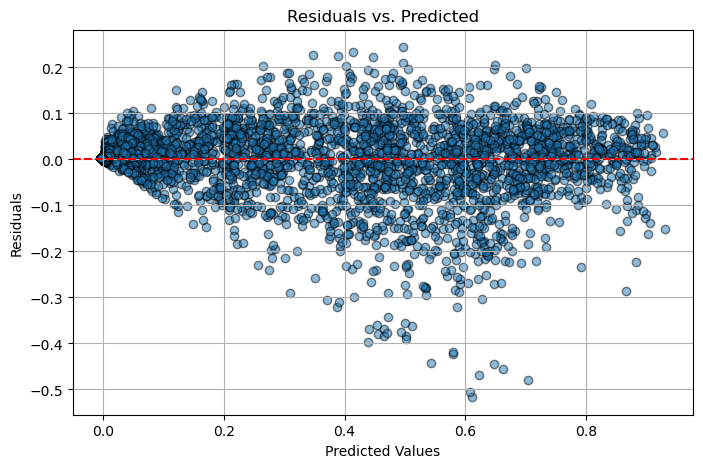

In [27]:
# Calculate residuals
residuals = y_val - y_pred

# Residuals plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_test_pred = model.predict(X_test).flatten()

# Calculate Test MAE
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test MAE: {test_mae}")

# Calculate Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse}")

# Calculate Test MSE
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

# Calculate Test R² Score
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test R² Score: {test_r2}")


189/189 [==============================] - 1s 6ms/step
Test MAE: 0.03048586061999267
Test RMSE: 0.05778696736941085
Test MSE: 0.003339333597753354
Test R² Score: 0.9547708043837015


In [29]:
def build_attention_extraction_model(trained_model, layer_name='transformer_encoder_1_attn'):
    # Get the model input and the encoded sequence output
    inputs = trained_model.input
    
    # Get the output after positional encoding (usually layer 3)
    norm_input = trained_model.layers[3].output  # Adjust index if needed
    
    # Recreate the attention layer manually
    attention_layer = trained_model.get_layer(layer_name)
    _, attn_scores = attention_layer(norm_input, norm_input, return_attention_scores=True)
    
    return Model(inputs=inputs, outputs=attn_scores)


1/1 [==============================] - 0s 125ms/step


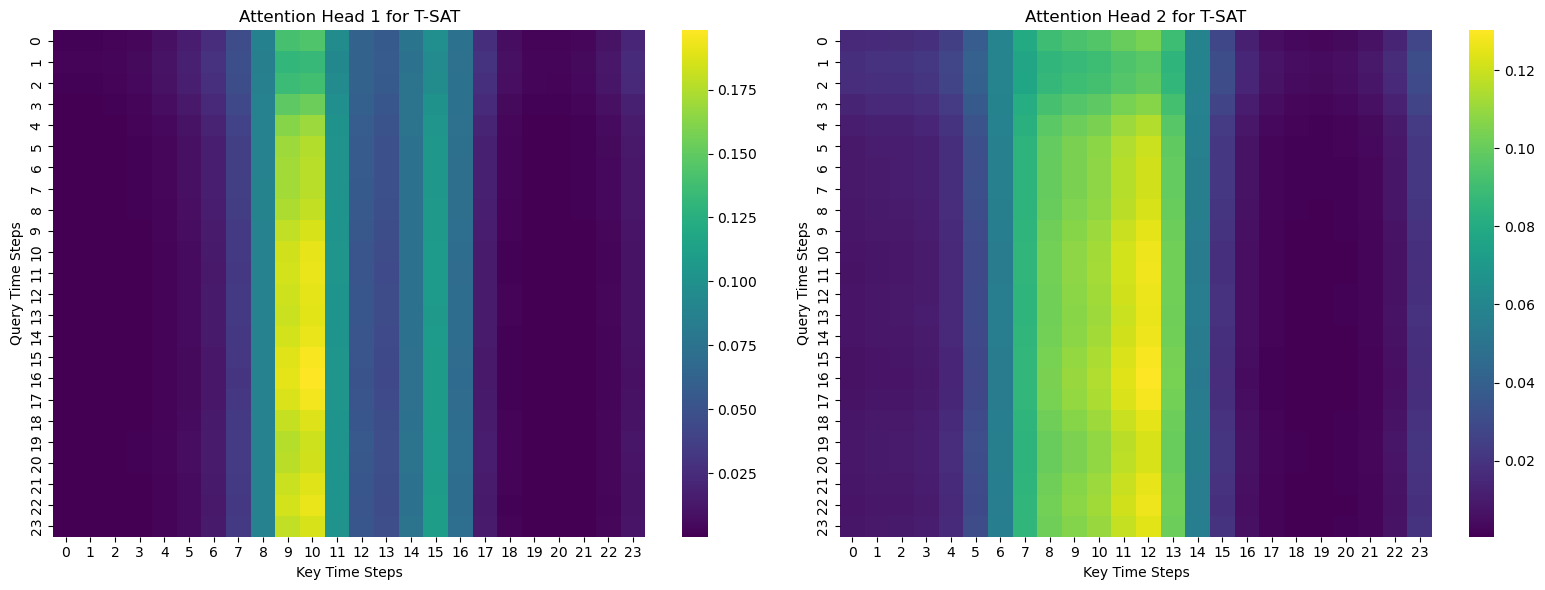

In [33]:
# Build attention model
attn_model = build_attention_extraction_model(model, layer_name='transformer_encoder_1_attn')

# Pick a sample from test set
sample = X_test[0:1]  

# Get attention scores
attn_scores = attn_model.predict(sample)  # shape: (1, num_heads, 24, 24)

# Visualize heatmap for each head
import seaborn as sns
import matplotlib.pyplot as plt

num_heads = attn_scores.shape[1]
head_indices = [0, 1]

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, head in enumerate(head_indices):
    sns.heatmap(attn_scores[0, head], ax=axes[i], cmap='viridis')
    axes[i].set_title(f'Attention Head {head + 1} for T-SAT')
    axes[i].set_xlabel("Key Time Steps")
    axes[i].set_ylabel("Query Time Steps")

plt.tight_layout()
plt.show()


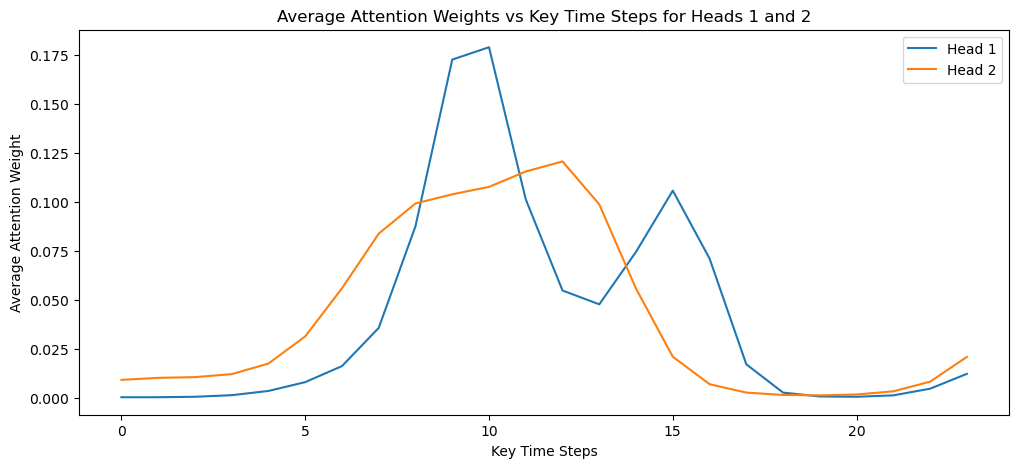

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assume attn_scores shape: (1, num_heads, seq_len, seq_len)
# Here, sample size = 1 for your single test sequence

# Extract heads 1 and 2 (index 0 and 1)
head_indices = [0, 1]

# Average attention weights over query time steps (dim=2)
# shape after mean: (1, num_heads, seq_len)
avg_attn_weights = attn_scores.mean(axis=2)  # average over query time steps

# Remove batch dimension for plotting
avg_attn_weights = avg_attn_weights[0]

# Plot average attention weights for Heads 1 and 2
plt.figure(figsize=(12,5))
for head in head_indices:
    plt.plot(avg_attn_weights[head], label=f'Head {head + 1}')
plt.xlabel('Key Time Steps')
plt.ylabel('Average Attention Weight')
plt.title('Average Attention Weights vs Key Time Steps for Heads 1 and 2')
plt.legend()
plt.show()


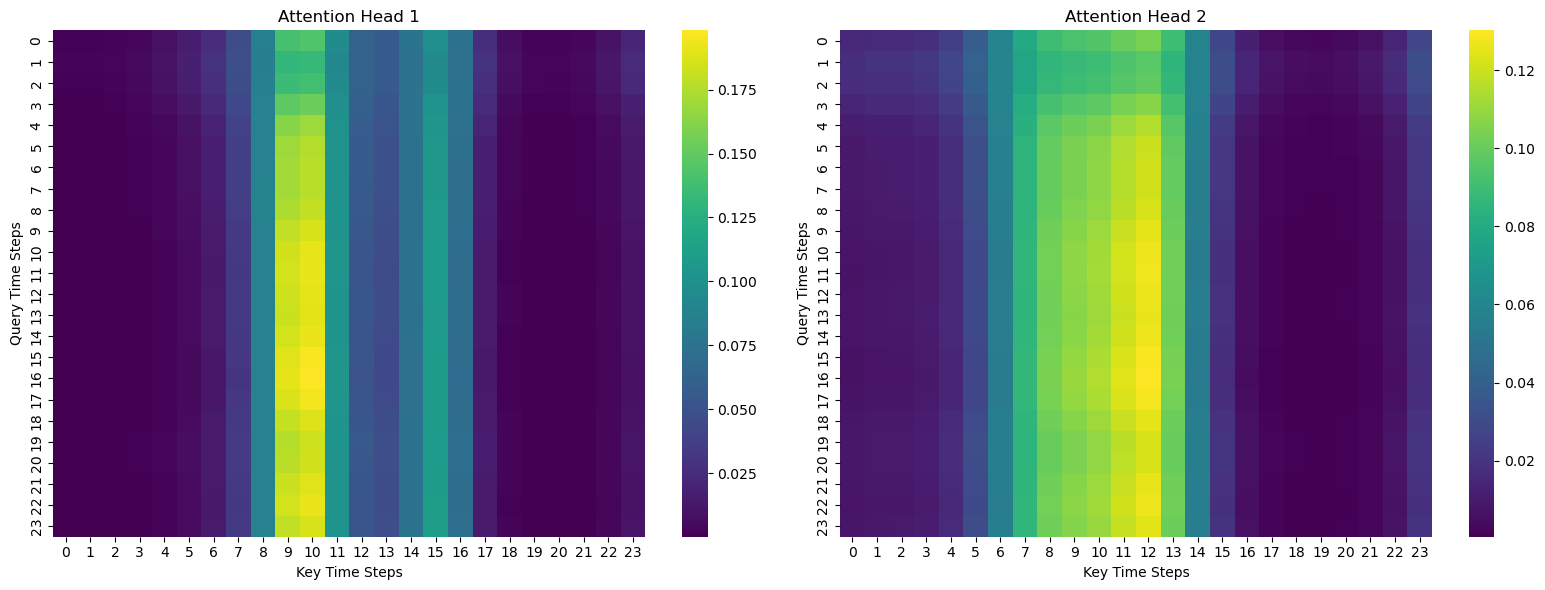

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

head_indices = [0, 1]  # Heads 1 and 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, head in enumerate(head_indices):
    sns.heatmap(attn_scores[0, head], cmap='viridis', ax=axes[i])
    axes[i].set_title(f'Attention Head {head + 1}')
    axes[i].set_xlabel('Key Time Steps')
    axes[i].set_ylabel('Query Time Steps')

plt.tight_layout()
plt.show()

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 12)]     0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 24, 64)       832         ['input_2[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 24, 64)       0           ['dense_9[0][0]']                
                                                                                                  
 positional_encoding_1 (Positio  (None, 24, 64)      0           ['dropout_7[0][0]']              
 nalEncoding)                                                                               

                                                                                                  
 dense_16 (Dense)               (None, 32)           2080        ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_17 (Dense)               (None, 1)            33          ['dense_16[0][0]']               
                                                                                                  
Total params: 78,593
Trainable params: 78,593
Non-trainable params: 0
__________________________________________________________________________________________________


<hr>

# **Model Performance Report**  

## **1. Overview**  
- **Model Type**: Supervised Learning (likely Regression, given MAE/RMSE metrics)  
- **Training Epochs**: 20  
- **Optimizer**: Likely Adam (default LR=0.001, reduced to 0.0002 in final epoch)  
- **Key Metrics Tracked**:  
  - Loss (Training & Validation)  
  - Mean Absolute Error (MAE)  
  - Root Mean Squared Error (RMSE)  
  - Mean Squared Error (MSE)  
  - R² Score  

---

## **2. Training & Validation Performance**  

### **Loss Trends**  
| **Metric**       | **Start (Epoch 1)** | **End (Epoch 20)** | **Convergence** |  
|------------------|---------------------|--------------------|-----------------|  
| Training Loss    | 1.4208              | 0.0041             | Strong          |  
| Validation Loss  | 0.7943              | 0.0043             | Strong          |  

- **Analysis**:  
  - Rapid initial improvement (loss drops by ~99% by epoch 5).  
  - No divergence between training/validation loss, indicating **no overfitting**.  
  - Final losses nearly identical (~0.004), suggesting optimal convergence.  

### **MAE Trends**  
| **Metric**       | **Start (Epoch 1)** | **End (Epoch 20)** | **Stability** |  
|------------------|---------------------|--------------------|---------------|  
| Training MAE     | 0.1196              | 0.0317             | Stable        |  
| Validation MAE   | 0.0545              | 0.0330             | Stable        |  

- **Analysis**:  
  - Validation MAE occasionally spikes (e.g., epoch 13: 0.054) but quickly recovers.  
  - Final MAE values are very close (~0.031 train vs. ~0.033 val), confirming generalization.  

---

## **3. Test Set Performance**  
| **Metric**   | **Value**          | **Interpretation**               |  
|--------------|--------------------|-----------------------------------|  
| Test MAE     | 0.0308             | Excellent (aligns with val MAE)  |  
| Test RMSE    | 0.0571             | Low error dispersion              |  
| Test MSE     | 0.0033             | Squared errors minimal           |  
| **R² Score** | **0.956**          | **Highly predictive (≈96% variance explained)** |  

- **Key Insight**:  
  - Test metrics match validation results, confirming **no overfitting**.  
  - R² ≈ 0.956 indicates the model explains **95.6% of variability** in the target variable.  

---

## **4. Diagnostics & Recommendations**  

### **Potential Issues**  
1. **Epoch 13 Anomaly**:  
   - Temporary val MAE spike (0.054) may suggest:  
     - Small noisy validation subset.  
     - Mild optimizer instability (fixed by later epochs).  

2. **Learning Rate Adjustment**:  
   - Final LR reduction (to 0.0002) had minimal impact. Could be omitted or tested earlier.  

### **Recommendations**  
✅ **No Overfitting Detected**: Proceed as-is.  
✅ **Early Stopping**: Could halt at epoch 15 (metrics stabilized by then).  
🔧 **Optional Experiments**:  
   - Try dropout/L2 regularization if future overfitting observed.  
   - Cross-validation to ensure consistency.  

---

